**MLZoomcamp Homework 4**

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [2]:
#Import dataset
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv

--2022-10-04 03:46:23--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73250 (72K) [text/plain]
Saving to: ‘AER_credit_card_data.csv.1’

AER_credit_card_dat 100%[===================>]  71.53K  --.-KB/s    in 0.02s   

2022-10-04 03:46:24 (2.98 MB/s) - ‘AER_credit_card_data.csv.1’ saved [73250/73250]



In [3]:
df_credit = pd.read_csv("AER_credit_card_data.csv")

In [4]:
#Initial exploration of the data
df_credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319 entries, 0 to 1318
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   card         1319 non-null   object 
 1   reports      1319 non-null   int64  
 2   age          1319 non-null   float64
 3   income       1319 non-null   float64
 4   share        1319 non-null   float64
 5   expenditure  1319 non-null   float64
 6   owner        1319 non-null   object 
 7   selfemp      1319 non-null   object 
 8   dependents   1319 non-null   int64  
 9   months       1319 non-null   int64  
 10  majorcards   1319 non-null   int64  
 11  active       1319 non-null   int64  
dtypes: float64(4), int64(5), object(3)
memory usage: 123.8+ KB


In [5]:
df_credit.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


In [6]:
categorical_columns = list(df_credit.dtypes[df_credit.dtypes == 'object'].index)
numerical_columns = list(df_credit.dtypes[df_credit.dtypes != 'object'].index)

In [7]:
#Create target variable
df_credit["card_target"] = (df_credit["card"] == 'yes').astype(int)

In [8]:
#Split dataset in train, validation and test sets

df_credit_full_train, df_credit_test = train_test_split(df_credit, test_size=0.2, random_state=1)
df_credit_train, df_credit_val = train_test_split(df_credit_full_train, test_size=0.25, random_state=1)

df_credit_train = df_credit_train.reset_index(drop=True)
df_credit_val = df_credit_val.reset_index(drop=True)
df_credit_test = df_credit_test.reset_index(drop=True)

y_train = df_credit_train.card_target.values
y_val = df_credit_val.card_target.values
y_test = df_credit_test.card_target.values

**Question 1**

In [9]:
from sklearn.metrics import roc_auc_score

for var in numerical_columns:
    auc = roc_auc_score(y_train, df_credit_train[var])
    print("For variable", var, " AUC is", auc)
    

For variable reports  AUC is 0.28333701393106236
For variable age  AUC is 0.4759979020592945
For variable income  AUC is 0.5908049467233478
For variable share  AUC is 0.989183643423692
For variable expenditure  AUC is 0.991042345276873
For variable dependents  AUC is 0.46722427722262094
For variable months  AUC is 0.470578221903237
For variable majorcards  AUC is 0.5343859842838476
For variable active  AUC is 0.6043173411362006


In [10]:
#Repeat for AUC<0.5
for var in ["reports", "age", "dependents", "months"]:
    auc = roc_auc_score(y_train, -df_credit_train[var])
    print("For variable", var, " AUC is", auc)

For variable reports  AUC is 0.7166629860689376
For variable age  AUC is 0.5240020979407055
For variable dependents  AUC is 0.5327757227773791
For variable months  AUC is 0.5294217780967629


**Question 2**

In [11]:
#Select variables of interest
selected_features = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]

In [12]:
df_credit_train = df_credit_train[selected_features]
df_credit_val = df_credit_val[selected_features]
df_credit_test = df_credit_test[selected_features]

Index(['reports', 'age', 'income', 'share', 'expenditure', 'dependents',
       'months', 'majorcards', 'active', 'owner', 'selfemp'],
      dtype='object')

In [13]:
#Apply one-hot-encoding using DictVectorizer
dv = DictVectorizer(sparse=False)

train_dict = df_credit_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

In [14]:
#Fit logistic regression model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [15]:
#Calculate AUC 
val_dict = df_credit_val.to_dict(orient='records')
X_val = dv.transform(val_dict)
y_val_pred = model.predict_proba(X_val)[:,1]
round(roc_auc_score(y_val, y_val_pred),3)

0.995

**Question 3**

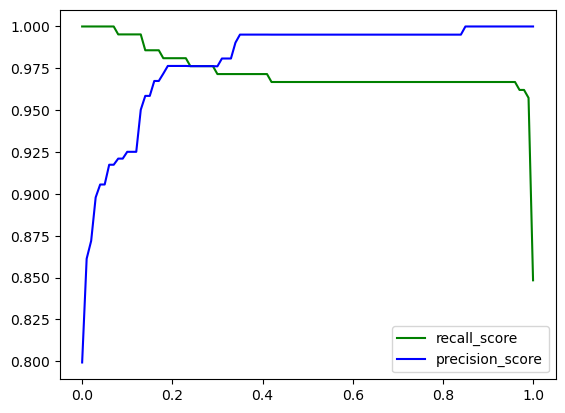

In [16]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

#Set-up threshold variable
thresholds = np.linspace(0, 1, 101)

scores = []

for t in thresholds:
    r_score = recall_score(y_val, y_val_pred >= t)
    p_score = precision_score(y_val, y_val_pred >= t)
    scores.append((t, r_score, p_score))

columns = ["threshold", "r_score", "p_score"]
df_scores = pd.DataFrame(scores, columns=columns)

plt.plot(df_scores["threshold"], df_scores["r_score"], color="green", label="recall_score")
plt.plot(df_scores["threshold"], df_scores["p_score"], color="blue", label="precision_score")
plt.legend()

**Question 4**

In [17]:
#Function to calculate F1
def f1_score(r_score, p_score):
    return (r_score * p_score) / (r_score + p_score)

In [18]:
f1_scores = []

for t in thresholds:
    r_score = recall_score(y_val, y_val_pred >= t)
    p_score = precision_score(y_val, y_val_pred >= t)
    f1 = f1_score(r_score, p_score)
    f1_scores.append((t, f1))

columns = ["threshold", "f1_score"]
df_f1_scores = pd.DataFrame(f1_scores, columns=columns)

max_f1 = df_f1_scores["f1_score"].max()
position_f1_max = df_f1_scores[df_f1_scores["f1_score"]==max_f1].index
position_f1_max
max_t = df_f1_scores["threshold"][position_f1_max[3]]
max_t


0.38

**Question 5**

In [19]:
from sklearn.model_selection import KFold

In [22]:
auc_scores = []

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_credit_full_train):
    df_train = df_credit_full_train.iloc[train_idx]
    df_val = df_credit_full_train.iloc[val_idx]

    y_train = df_train.card_target.values
    y_val = df_val.card_target.values
    
    df_train = df_train[selected_features]
    df_val = df_val[selected_features]
    
    dv = DictVectorizer(sparse=False)
    train_dict = df_train.to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
    
    val_dict = df_val.to_dict(orient='records')
    X_val = dv.transform(val_dict)
    y_pred = model.predict_proba(X_val)[:,1]
 
    auc = roc_auc_score(y_val, y_pred)
    auc_scores.append(auc)

print(auc_scores)
np.std(auc_scores)

[0.9941860465116279, 0.9941176470588236, 0.9943346508563901, 0.9996107939802803, 1.0]


0.0027434713804377724

**Question 6**

In [23]:
auc_scores_c = []

for c in [0.01, 0.1, 1, 10]:
    
    auc_scores = []

    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    for train_idx, val_idx in kfold.split(df_credit_full_train):
        df_train = df_credit_full_train.iloc[train_idx]
        df_val = df_credit_full_train.iloc[val_idx]

        y_train = df_train.card_target.values
        y_val = df_val.card_target.values
        
        df_train = df_train[selected_features]
        df_val = df_val[selected_features]    

        dv = DictVectorizer(sparse=False)
        train_dict = df_train.to_dict(orient='records')
        X_train = dv.fit_transform(train_dict)

        model = LogisticRegression(solver='liblinear', C=c, max_iter=1000)
        model.fit(X_train, y_train)

        val_dict = df_val.to_dict(orient='records')
        X_val = dv.transform(val_dict)
        y_pred = model.predict_proba(X_val)[:,1]

        auc = roc_auc_score(y_val, y_pred)
        auc_scores.append(auc)

    auc_scores_c.append((c, np.mean(auc_scores), np.std(auc_scores)))

auc_scores_c
    

[(0.01, 0.9918810292344007, 0.00559887235402738),
 (0.1, 0.9950557137157224, 0.003954138088244392),
 (1, 0.9964498276814243, 0.0027434713804377724),
 (10, 0.9963886109436032, 0.0028151486609295684)]